# Portfolio Optimization Spreadsheet

## Setup environment

In [240]:
import base64
import math
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as pd

## Initialize api

In [241]:
base_url = 'https://optimize.vicbee.net/api/'
#base_url = 'http://localhost/api/'
        
# get token
username = 'demo@optimize.vicbee.net'
password = 'optimize'
headers = {
    'Content-type': 'application/json',
    'Accept': 'application/json',
    'Authorization': 'Basic ' + base64.b64encode(bytes('{}:{}'.format(username, password), 'utf-8')).decode('utf-8')
}

resp = requests.get(base_url + 'get_token', headers=headers)

if resp.ok:

    token = resp.json().get('token')
    duration = resp.json().get('duration')
    print('> Got authentication token')
    print('  token = {}'.format(token))
    print('> Token expires in {} minutes. Rerun this cell to renew token.'.format(duration/60))

else:

    resp.raise_for_status()

headers = {
    'Content-type': 'application/json',
    'Accept': 'application/json',
    'X-Api-Key': token
}

> Got authentication token
  token = eyJhbGciOiJIUzUxMiIsImlhdCI6MTU2ODgzMzYwMiwiZXhwIjoxNTY4ODM0MjAyfQ.eyJpZCI6Mn0.Z4OQ22xYfsGKs_nNrZUOkGiTjH8PsHeTOLugEoL-9uSoFoKZkYDPZ_f7lOPY-fgQwwCIlTSSuGABDtC0oAfi1Q
> Token expires in 10.0 minutes. Rerun this cell to renew token.


# Portfolio Optimization

## Setup data using pandas dataframe

In [252]:
data = [
    ['S & P',14.0,18.5,0.8,.3,np.inf],
    ['Bonds',6.5,5.0,0.1,.1,np.inf],
    ['Canadian',11.0,16.0,0.3,-np.inf,np.inf],
    ['Japan',14.0,23.0,0.1,-np.inf,np.inf],
    ['Emerging Markets',16.0,30.0,0.5,-np.inf,np.inf],
    ['Pacific',18.0,26.0,0.5,-np.inf,np.inf],
    ['Europe',12.0,20.0,0.4,-np.inf,np.inf],
    ['Small Stocks',17.0,24.0,0.1,-np.inf,np.inf] 
]
assets = pd.DataFrame(data, columns=['Label', 'Return (%)', 'STD (%)', 'Position', 'Lower', 'Upper'])
assets.Position = assets.Position / assets.Position.sum()
assets

,Label,Return (%),STD (%),Position,Lower,Upper
0,S & P,14.0,18.5,0.285714,0.300000,inf
1,Bonds,6.5,5.0,0.035714,0.100000,inf
2,Canadian,11.0,16.0,0.107143,-inf,inf
3,Japan,14.0,23.0,0.035714,-inf,inf
4,Emerging Markets,16.0,30.0,0.178571,-inf,inf
5,Pacific,18.0,26.0,0.178571,-inf,inf
6,Europe,12.0,20.0,0.142857,-inf,inf
7,Small Stocks,17.0,24.0,0.035714,-inf,inf


In [253]:
n = len(assets)
data = np.array([
    [1,.45,.7,.2,.64,.3,.61,.79],
    [.45,1,.27,-.01,.41,.01,.13,.28],
    [.7,.27,1,.14,.51,.29,.48,.59],
    [.2,-.01,.14,1,.25,.73,.56,.13],
    [.64,.41,.51,.25,1,.28,.61,.75],
    [.3,.01,.29,.73,.28,1,.54,.16],
    [.61,.13,.48,.56,.61,.54,1,.44],
    [.79,.28,.59,.13,.75,.16,.44,1]
])
cov = pd.DataFrame(data=data, columns=assets.Label.values, index=assets.Label.values)
cov

,S & P,Bonds,Canadian,Japan,Emerging Markets,Pacific,Europe,Small Stocks
S & P,1.00,0.45,0.70,0.20,0.64,0.30,0.61,0.79
Bonds,0.45,1.00,0.27,-0.01,0.41,0.01,0.13,0.28
Canadian,0.70,0.27,1.00,0.14,0.51,0.29,0.48,0.59
Japan,0.20,-0.01,0.14,1.00,0.25,0.73,0.56,0.13
Emerging Markets,0.64,0.41,0.51,0.25,1.00,0.28,0.61,0.75
Pacific,0.30,0.01,0.29,0.73,0.28,1.00,0.54,0.16
Europe,0.61,0.13,0.48,0.56,0.61,0.54,1.00,0.44
Small Stocks,0.79,0.28,0.59,0.13,0.75,0.16,0.44,1.00


## Build problem data

In [254]:
# vector of expected returns
r = assets['Return (%)'].values/100

# covariance matrix
sigmas = np.diag(assets['STD (%)'].values)/100
Q = sigmas @ cov.values @ sigmas

# current positions
x0 = assets['Position'].values

# lower bounds
xlo = assets['Lower'].values

# Upper bounds
xup = assets['Upper'].values

In [255]:
# cashflow
cashflow = 1

# expected return
mu = 0.14

# sell (set to False to prevent selling stocks)
sell = True

# buy (set to False to prevent buying stocks)
buy = True

# short (set to False to prevent short sales)
short = True

# options
options = {
    'sell': sell,
    'buy': buy,
    'short': short
}

## Submit problem to the api

In [256]:
# prepare data for submitting request to api

data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'x0': x0.tolist(),
    'xlo': xlo.tolist(),
    'xup': xup.tolist(),
    'mu': mu,
    'cashflow': cashflow,
    'options': options
}

resp = requests.post(base_url + 'portfolio',
                     json=data,
                     headers=headers)

if resp.ok:

    sol = resp.json()
    print('> Got solution')
    if sol['obj'] is not None:
        print('  * mu = {:.3f}%, std = {:.3f}% ({})'.format(100*mu, 100*math.sqrt(sol['obj']), sol['status']))
        print('  * solution = {}'.format(sol['x']))
    else:
        print('  * mu = {:.3f}%, std = --- ({})'.format(100*mu, sol['status']))
else:

    print(resp.json())
    resp.raise_for_status()

> Got solution
  * mu = 14.000%, std = 12.959% (optimal)
  * solution = [0.2999999957278775, 0.7224496894771588, -0.11266759772470511, 0.16256566838119046, -0.22256789533440097, 0.6509573960548254, -0.2847773115484372, 0.7840400918349191]


# Efficient Frontier

## Setup

In [257]:
# cashflow
cashflow = 1

# sell (set to False to prevent selling stocks)
sell = True

# buy (set to False to prevent buying stocks)
buy = True

# short (set to False to prevent short sales)
short = False

# number of points on the frontier to calculate
number_of_points = 30

# options
options = {
    'sell': sell,
    'buy': buy,
    'short': short,
    'number_of_points': number_of_points
}

## Submit problem to the api

In [258]:
# prepare data for submitting request to api

data = {
    'Q': Q.tolist(),
    'r': r.tolist(),
    'x0': x0.tolist(),
    'xlo': xlo.tolist(),
    'xup': xup.tolist(),
    'cashflow': cashflow,
    'options': options
}

resp = requests.post(base_url + 'frontier',
                     json=data,
                     headers=headers)

if resp.ok:

    sol = resp.json()
    print('> Got frontier')
    m = len(sol['frontier'])
    mu = np.zeros((m,))
    variance = np.zeros((m,))
    holdings = np.zeros((m, n))
    for i, e in enumerate(sol['frontier']):
        sol = e['sol']
        mu[i] = e['mu']
        variance[i] = sol['obj']
        holdings[i, :] = sol['x']
        if sol['obj'] is not None:
            print('  {}. mu = {:.3f}%, std = {:.3f}% ({})'.format(i+1, 100*mu[i], 100*math.sqrt(sol['obj']), sol['status']))
        else:
            print('  {}. mu = {:.3f}%, std = --- ({})'.format(i+1, 100*mu[i], sol['status']))
else:

    print(resp.json())
    resp.raise_for_status()

> Got frontier
  1. mu = 7.837%, std = 5.995% (optimal)
  2. mu = 8.187%, std = 6.081% (optimal)
  3. mu = 8.538%, std = 6.280% (optimal)
  4. mu = 8.888%, std = 6.572% (optimal)
  5. mu = 9.239%, std = 6.919% (optimal)
  6. mu = 9.589%, std = 7.298% (optimal)
  7. mu = 9.939%, std = 7.705% (optimal)
  8. mu = 10.290%, std = 8.136% (optimal)
  9. mu = 10.640%, std = 8.586% (optimal)
  10. mu = 10.991%, std = 9.053% (optimal)
  11. mu = 11.341%, std = 9.535% (optimal)
  12. mu = 11.692%, std = 10.029% (optimal)
  13. mu = 12.042%, std = 10.534% (optimal)
  14. mu = 12.393%, std = 11.047% (optimal)
  15. mu = 12.743%, std = 11.569% (optimal)
  16. mu = 13.094%, std = 12.098% (optimal)
  17. mu = 13.444%, std = 12.632% (optimal)
  18. mu = 13.795%, std = 13.172% (optimal)
  19. mu = 14.145%, std = 13.717% (optimal)
  20. mu = 14.495%, std = 14.266% (optimal)
  21. mu = 14.846%, std = 14.818% (optimal)
  22. mu = 15.196%, std = 15.374% (optimal)
  23. mu = 15.547%, std = 15.933% (optimal)


## Plot frontier

In [259]:
rmax = np.max(r)
rmin = np.min((np.min(r), np.min(mu)))
dr = rmax - rmin
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

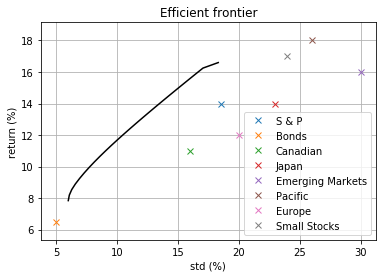

In [260]:
# plot frontier
xlim = (100*(rmin-0.1*dr), 100*(rmax+0.1*dr))

for i, label in enumerate(assets['Label'].values): 
    plt.plot(100*np.sqrt(Q[i,i]), 100*r[i], 'x', color=colors[np.mod(i, len(colors))])
plt.plot(100*np.sqrt(variance), 100*mu, 'k')
plt.xlabel('std (%)')
plt.ylabel('return (%)')
plt.title('Efficient frontier')
plt.ylim(xlim)
plt.legend(assets['Label'].values)
plt.grid()
plt.show()

## Plot sells, buys, holdings

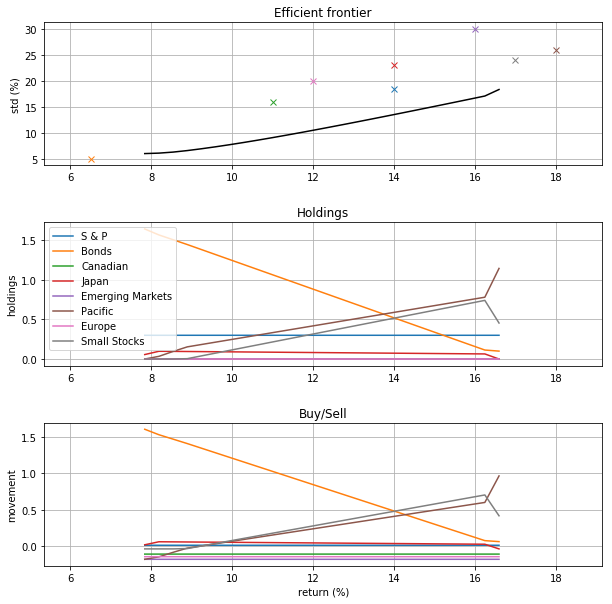

In [261]:
# plot frontier
xlim = (100*(rmin-0.1*dr), 100*(rmax+0.1*dr))
plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 1, 1)
for i, label in enumerate(assets['Label'].values): 
    plt.plot(100*r[i], 100*np.sqrt(Q[i,i]), 'x', color=colors[np.mod(i, len(colors))])
ax.plot(100*mu, 100*np.sqrt(variance), 'k')
ax.set_ylabel('std (%)')
ax.set_title('Efficient frontier')
ax.set_xlim(xlim)
ax.grid()

ax = plt.subplot(3, 1, 2)
ax.plot(100*mu, holdings)
ax.set_ylabel('holdings')
ax.set_title('Holdings')
ax.set_xlim(xlim)
ax.legend(assets['Label'].values)
ax.grid()

ax = plt.subplot(3, 1, 3)
ax.plot(100*mu, holdings - x0)
ax.set_xlabel('return (%)')
ax.set_ylabel('movement')
ax.set_title('Buy/Sell')
ax.set_xlim(xlim)
ax.grid()

plt.subplots_adjust(hspace=.4)
plt.show()